In [1]:
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from functools import partial
import xarray as xr
import glob
import pandas as pd
import os

functions

In [2]:
def destagger(var, stagger_dim):
    '''
    From wrf-python 
    https://github.com/NCAR/wrf-python/blob/b40d1d6e2d4aea3dd2dda03aae18e268b1e9291e/src/wrf/destag.py 
    '''
    var_shape = var.shape
    num_dims = var.ndim
    stagger_dim_size = var_shape[stagger_dim]

    full_slice = slice(None)
    slice1 = slice(0, stagger_dim_size - 1, 1)
    slice2 = slice(1, stagger_dim_size, 1)

    dim_ranges_1 = [full_slice] * num_dims
    dim_ranges_2 = [full_slice] * num_dims

    dim_ranges_1[stagger_dim] = slice1
    dim_ranges_2[stagger_dim] = slice2

    result = .5*(var[tuple(dim_ranges_1)] + var[tuple(dim_ranges_2)])

    return result

In [3]:
def classify_stability(arr, metric='obk'):
    '''
    Map -1, 0, 1 to the three different stability classifications: unstable, neutral, stable
    '''
    if metric == 'obk':
        arr[np.where((arr<0) & (arr>-1000))] = -1
        arr[np.where((arr>1000) | (arr<-1000))] = 0
        arr[np.where((arr>0) & (arr<1000))] = 1
    else:
        arr[np.where((arr<0))] = -1
        arr[np.where((arr>0))] = 1
    
    return arr

In [4]:
def make_dict(data, use_pct=True):
    '''
    Create a dictionary that contains the stability counts for each month
    e.g: dict = {'Unstable': [jan, feb, march...], 'Neutral': [jan, ...], ...}
    '''
    unstable = []
    neutral = []
    stable = []
    for month in data:
        # calculate stability
        stab = classify_stability(month.RMOL)
        stab_counts = stab.groupby(stab).count().values
        if use_pct:
            ttl = stab_counts.sum()
            unstable.append((stab_counts[0]/ttl)*100)
            neutral.append((stab_counts[1]/ttl)*100)
            stable.append((stab_counts[2]/ttl)*100)
        else:
            unstable.append(stab_counts[0])
            neutral.append(stab_counts[1])
            stable.append(stab_counts[2])
    
    sdict = {'Unstable': np.array(unstable),
             'Neutral': np.array(neutral),
             'Stable': np.array(stable)}
    return sdict

In [5]:
# determine if wrf and calc agree
def find_agreement(wrf, calc):
    '''
    Strong disagreement (SD): stable vs unstable
    Weak disagreement (WD): stable/unstable vs neutral
    Agreement (A): agree
    '''
    
    # classify stability
    wrf = classify_stability(1/wrf.RMOL).values
    calc = classify_stability(calc.RMOL).values
    
    # determine if they agree
    dif = np.abs(wrf - calc)
    
    agreement = ['SD' if val == 2 else 'WD' if val == 1 else 'A' for val in dif]
    
    return agreement

### remake wrf calc scatter plot

In [7]:
wrf_data = xr.open_dataset('../detection2/RMOL.nc')
wrf_data = np.where(wrf_data.RMOL.values == 0, 0.000001, wrf_data.RMOL.values) # remove 0s
# wrf_data = np.where(wrf_data.RMOL.values == 0, np.nan, wrf_data.RMOL.values) # remove 0s
wrf = 1/wrf_data
calc = xr.open_dataset('../rmol_data/rmol_calc_vwmid3.nc')

#### separate data into quadrants
    - Quadrant 1: wrf and calc both greater than 0
    - quadrant 2: wrf > 0, calc < 0
    - quadrant 3: wrf and calc both < 0
    - quadrant 4: wrf < 0, calc > 0

In [8]:
def assign_color(wrf, calc):
    '''
    Create an array of colors that correspond to the quadrant the data point will fall into
    '''
    colors = list(np.zeros(len(wrf)))
    quads = np.zeros(len(wrf))
    
    q1 = np.where((wrf > 0) & (calc.RMOL.values > 0))[0]
    q2 = np.where((wrf > 0) & (calc.RMOL.values < 0))[0]
    q3 = np.where((wrf < 0) & (calc.RMOL.values < 0))[0]
    q4 = np.where((wrf < 0) & (calc.RMOL.values > 0))[0]
    
    quads[q1] = 1
    quads[q2] = 2
    quads[q3] = 3
    quads[q4] = 4
    
    for i in range(len(quads)):
        colors[i] = get_color(quads[i])
    
    return colors, len(q1), len(q2), len(q3), len(q4)

In [9]:
def get_color(val):
    if val == 1:
        return 'steelblue'
    if val == 2:
        return 'mediumpurple'
    if val == 3:
        return 'firebrick'
    if val == 4:
        return 'mediumorchid'

In [10]:
colors, q1, q2, q3, q4 = assign_color(wrf, calc)

In [10]:
q1, q2, q3, q4

(22909, 318, 26810, 2667)

In [11]:
sum([q1, q2, q3, q4])

52704

Calculated  1/L [m-1]" and "WRF" with "WRF output RMOL [m-1

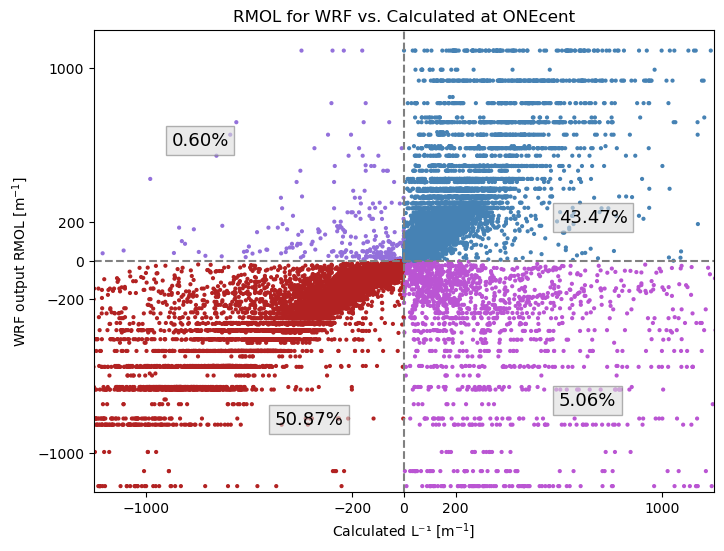

In [13]:
# original code
plt.figure(figsize=(8, 6))
ax = plt.gca()

plt.scatter(calc.RMOL.values, wrf, s=4, c=colors)
plt.xlim(-1200, 1200)
plt.ylim(-1200, 1200)
plt.xlabel(r'Calculated L⁻¹ [$\mathregular{m^{-1}}$]')
plt.ylabel(r'WRF output RMOL [$\mathregular{m^{-1}}$]')
plt.xticks([-1000, -200, 0, 200, 1000])
plt.yticks([-1000, -200, 0, 200, 1000])
plt.title('RMOL for WRF vs. Calculated at ONEcent')
ax.axvline(0, color='grey', linestyle='dashed')
ax.axhline(0, color='grey', linestyle='dashed')

t1 = ax.text(600, 200, f'{q1/52704 *100:.2f}%', fontsize=13)
t2 = ax.text(-900, 600, f'{q2/52704 *100:.2f}%', fontsize=13)
t3 = ax.text(-500, -850, f'{q3/52704 *100:.2f}%', fontsize=13)
t4 = ax.text(600, -750, f'{q4/52704 *100:.2f}%', fontsize=13)

for t in [t1, t2, t3, t4]:
    t.set_bbox(dict(facecolor='gainsboro', alpha=0.6, edgecolor='grey'))
    
plt.savefig('../output_plots/paper_plots/wrfvscalc_color.png', bbox_inches='tight')

### 1. Recreate fig 6 and 7 from Daves paper using calculated rmol

In [6]:
d1 = xr.open_dataset('../detection2/rmol_files/RMOL_VWmid_2020_01.nc')
d2 = xr.open_dataset('../detection2/rmol_files/RMOL_VWmid_2020_02.nc')
d3 = xr.open_dataset('../detection2/rmol_files/RMOL_VWmid_2020_03.nc')
d4 = xr.open_dataset('../detection2/rmol_files/RMOL_VWmid_2020_04.nc')
d5 = xr.open_dataset('../detection2/rmol_files/RMOL_VWmid_2020_05.nc')
d6 = xr.open_dataset('../detection2/rmol_files/RMOL_VWmid_2020_06.nc')
d7 = xr.open_dataset('../detection2/rmol_files/RMOL_VWmid_2020_07.nc')
d8 = xr.open_dataset('../detection2/rmol_files/RMOL_VWmid_2020_08.nc')
d9 = xr.open_dataset('../detection2/rmol_files/RMOL_VWmid_2019_09.nc')
d10 = xr.open_dataset('../detection2/rmol_files/RMOL_VWmid_2019_10.nc')
d11 = xr.open_dataset('../detection2/rmol_files/RMOL_VWmid_2019_11.nc')
d12 = xr.open_dataset('../detection2/rmol_files/RMOL_VWmid_2019_12.nc')

In [7]:
f1 = [d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11, d12]
# for i in f:
#     print(len(i.RMOL))

d1.RMOL.values

classify_stability(d1.RMOL)

d1.RMOL.values

#### figure 6

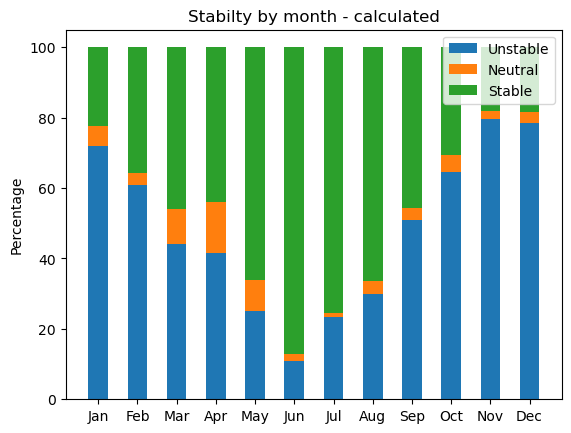

In [8]:
# make plot
names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
data = make_dict(f1)

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(12)

for boolean, weight_count in data.items():
    p = ax.bar(names, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Stabilty by month - calculated")
ax.set_ylabel('Percentage')
ax.legend(loc="upper right")

# plt.savefig('../f6.png')

#### fig 7

In [9]:
times = pd.date_range("2019/09/01", "2020/09/01", freq='10min')[:-1]

In [10]:
calc = xr.concat(f1, dim='dim_0').assign_coords(time=times)

In [11]:
calc_u = calc.copy()
calc_n = calc.copy()
calc_s = calc.copy()

In [12]:
calc_u['RMOL'] = xr.where(calc.RMOL==-1, 1, np.nan)
calc_n['RMOL'] = xr.where(calc.RMOL==0, 1, np.nan)
calc_s['RMOL'] = xr.where(calc.RMOL==1, 1, np.nan)

In [29]:
calc_u.groupby(calc_u.time.dt.month)[1].groupby(calc_u.groupby(calc_u.time.dt.month)[1].time.dt.hour)[1]#.RMOL.sum()

<xarray.Dataset>
Dimensions:  (dim_0: 52704, time: 186)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T01:00:00 ... 2020-01-31T01:50:00
Dimensions without coordinates: dim_0
Data variables:
    RMOL     (dim_0) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... nan nan nan 1.0 1.0 1.0

In [34]:
calc_u

<xarray.Dataset>
Dimensions:  (dim_0: 52704, time: 52704)
Coordinates:
  * time     (time) datetime64[ns] 2019-09-01 ... 2020-08-31T23:50:00
Dimensions without coordinates: dim_0
Data variables:
    RMOL     (dim_0) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... nan nan nan 1.0 1.0 1.0

In [17]:
grid = np.zeros((12, 24))

In [18]:
for m in range(1, 13):
    for h in range(0, 24):
        count = calc_u.groupby(calc_u.time.dt.month)[m].groupby(calc_u.groupby(calc_u.time.dt.month)[m].time.dt.hour)[h].RMOL.sum()
        grid[m-1][h] = count

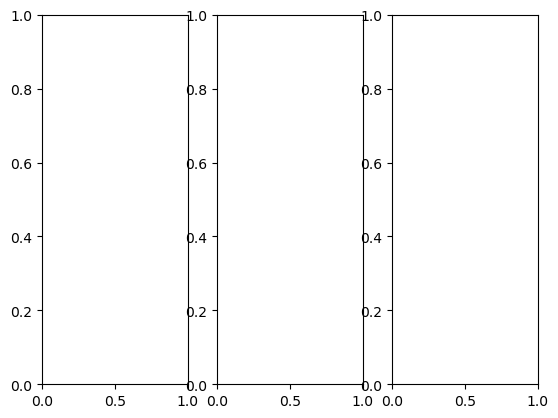

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=3)

# ask dave

### 2. Create a scatter plot of calculated vs WRF for all 12 months
    - also find % disagreement

In [7]:
wrf = xr.open_dataset('../detection2/RMOL.nc')

In [10]:
f = [d9, d10, d11, d12, d1, d2, d3, d4, d5, d6, d7, d8]
calc2 = xr.concat(f, dim='dim_0').assign_coords(time=times)

/tmp/ipykernel_2387324/1797041479.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(calc2.RMOL.values, 1/wrf.RMOL.values, s=4)


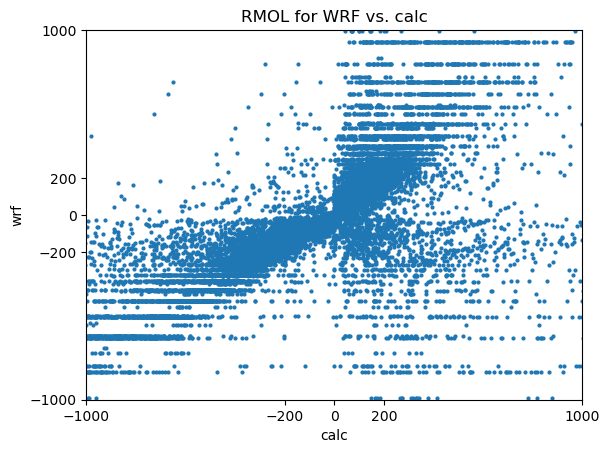

In [11]:
plt.scatter(calc2.RMOL.values, 1/wrf.RMOL.values, s=4)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.xlabel('calc')
plt.ylabel('wrf')
plt.xticks([-1000, -200, 0, 200, 1000])
plt.yticks([-1000, -200, 0, 200, 1000])
plt.title('RMOL for WRF vs. calc')

plt.savefig('../wrfvscalc.png', bbox_inches='tight');

In [12]:
pwd

'/projects/daqu2831/Lundquist_research/notebooks'

### 3. Create histogram of heat flux values for agreement levels

In [16]:
hfx = pd.read_csv('../HFX_all.csv').drop(columns=['Unnamed: 0']).rename(columns={'0': 'HFX'})

In [17]:
# add time to dataframe
hfx['time'] = times
hfx = hfx.set_index('time')

In [18]:
hfx['Agreement'] = find_agreement(wrf, calc2)

In [19]:
hfx_A = hfx[hfx.Agreement=='A']
hfx_WD = hfx[hfx.Agreement=='WD']
hfx_SD = hfx[hfx.Agreement=='SD']

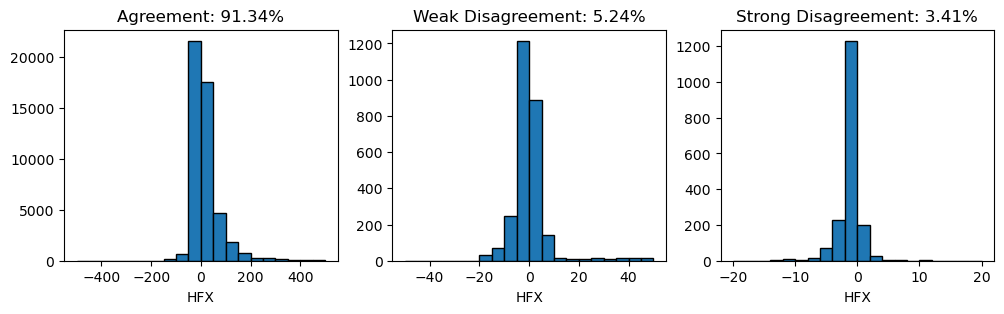

In [24]:
# now make the histogram for each one!
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

ax[0].hist(hfx_A.HFX, bins=np.arange(-500, 510, 50), edgecolor='k')
ax[1].hist(hfx_WD.HFX, bins=np.arange(-50, 51, 5), edgecolor='k')
ax[2].hist(hfx_SD.HFX, bins=np.arange(-20, 21, 2), edgecolor='k')

ax[0].set_title(f'Agreement: {(len(hfx_A) / len(hfx))*100:.2f}%')
ax[1].set_title(f'Weak Disagreement: {(len(hfx_WD) / len(hfx))*100:.2f}%')
ax[2].set_title(f'Strong Disagreement: {(len(hfx_SD) / len(hfx))*100:.2f}%')

ax[0].set_xlabel('HFX')
ax[1].set_xlabel('HFX')
ax[2].set_xlabel('HFX')

fig.savefig('../hfx_agreement.png');

In [49]:
for i in np.arange(0, 1.25, 0.25):
    print(i, hfx_SD.HFX.quantile(i))

0.0 -13.651092529296877
0.25 -1.6026673316955566
0.5 -0.8465922474861146
0.75 -0.34887658059597015
1.0 27.232458114624023


In [76]:
# find % disagreement
((len(hfx_WD)+len(hfx_SD)) / len(hfx)) * 100

8.65588949605343

below is code used to create hfx timeseries. no longer needed

pt1: 1-146
pt1_2: 147
pt2: 148-281
pt2_2 : 282
pt3 and pt4: 283-366

In [2]:
xr.open_dataset('/pl/active/JKL_REAL/N_Atl/reruns_Beiter/wrfouts/nwf/2019/09/wrfout_d02_2019-09-01_00:50:00')

<xarray.Dataset>
Dimensions:                (Time: 1, south_north: 258, west_east: 465,
                            bottom_top: 53, bottom_top_stag: 54,
                            soil_layers_stag: 4, west_east_stag: 466,
                            south_north_stag: 259, seed_dim_stag: 2)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag, seed_dim_stag
Data variables: (12/111)
    Times                  (Time) |S19 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    VAR_SSO                (Time, south_north, west_east) float32 ...
    ...                     ...
    C4H                    (Time, bottom_top) float32 ...
    C3F                    (Time, bottom_top_stag) float32 ...
    C4F                    (Time, bottom_top_stag) float32 ...
    PCB                    (Time, south_north, west_east) float32 ...
    PC                     (Time, south_north, west_east) float32 ...
    SST                    (Time, south_north, west_east) float32 ...
Attributes: (12/132)
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2019-08-31_12:00:00
    SIMULATION_START_DATE:           2019-08-31_12:00:00
    WEST-EAST_GRID_DIMENSION:        466
    SOUTH-NORTH_GRID_DIMENSION:      259
    BOTTOM-TOP_GRID_DIMENSION:       54
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

# Directory with wrfouts - 09-12 for 2019, 01-08 for 2020
nwf_data_dir_2019 = f"/pl/active/JKL_REAL/N_Atl/reruns_Beiter/wrfouts/nwf/2019/"
nwf_data_dir_2020 = f"/pl/active/JKL_REAL/N_Atl/reruns_Beiter/wrfouts/nwf/2020/"

# Select data from the entire year in domain 2
nwf_2019 = []
for i in range(9, 13):
    nwf_2019 = nwf_2019 + sorted([f for f in glob.glob(nwf_data_dir_2019+f"/{i:02}/wrfout_d02_2019-*")])
nwf_2020 = []
for i in range(1, 9):
    nwf_2020 = nwf_2020 + sorted([f for f in glob.glob(nwf_data_dir_2020+f"/{i:02}/wrfout_d02_2020-*")])
nwf_files_all = sorted(nwf_2019 + nwf_2020)
nwf_files_all = nwf_files_all

del nwf_2019, nwf_2020

# set up preprocessing to avoid issues with variables that do not match
variables = ['HFX']
def _preprocess(x):
    return x[variables]
partial_func = partial(_preprocess)

lon_idx = 232
lat_idx = 191

HFX_list = []
for period in range(282, 283):  # loop through each day of the year 
    print(f'-----{period}-----')
    # select a 24 hour long period
    nwf_files = nwf_files_all[period*144:(period*144)+144] # 144 10 minute periods in a day
    
    if period not in np.arange(60, 67):
        ds = xr.open_mfdataset(nwf_files, 
                               concat_dim = 'Time',
                               combine = 'nested',
                               parallel = True,
                               engine = 'netcdf4',
                               chunks = {'Time':1})
    else:
        ds = xr.open_mfdataset(nwf_files, 
                               concat_dim = 'Time',
                               combine = 'nested',
                               parallel = True,
                               engine = 'netcdf4',
                               chunks = {'Time':1},
                               preprocess=partial_func)
    HFX = ds.HFX
    HFX = HFX.sel(south_north=lat_idx, west_east=lon_idx)
    HFX_list = HFX_list + list(HFX.values)
    del HFX
np.savetxt(f'HFX_pt2_1.csv', np.array(HFX_list), delimiter=',')

# create list of files in dataframes folder
files = ['./HFX_pt1.csv', './HFX_pt1_2.csv', './HFX_pt2.csv', './HFX_pt2_1.csv', './HFX_pt3.csv', './HFX_pt4.csv']

df = pd.DataFrame()
for file in files:
    data = pd.read_csv(file, header=None)
    df = pd.concat([df, data], axis=0)

# save as csv file
df.to_csv('./HFX_all.csv')

### 4. Calculate BRN for the rotor disk region for the year
    - in progress
    - create a histogram of BRN values

In [25]:
df = pd.read_csv('../BRN_full.csv').drop(columns=['Unnamed: 0']).rename(columns={'0': 'BRN'})

#### make the histogram - most data is between -1.5 and 1.5

In [26]:
for i in np.arange(0, 1.25, 0.25):
    print(i, df.BRN.quantile(i))

0.0 -10098.482891720236
0.25 -0.641938692026617
0.5 0.3585448634629613
0.75 1.4187005456140462
1.0 11789632.356316252


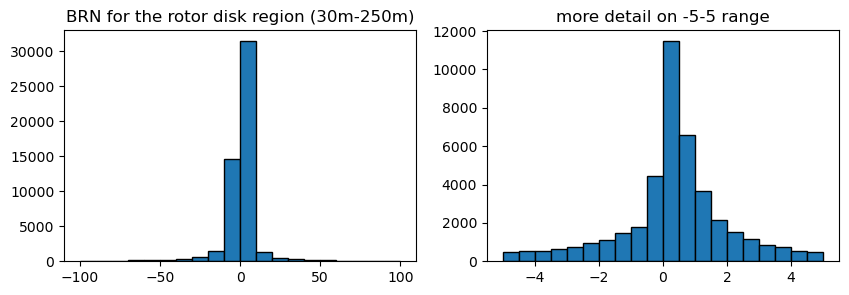

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

ax[0].hist(df.BRN, bins=np.arange(-100, 110, 10), edgecolor='k')
ax[0].set_title('BRN for the rotor disk region (30m-250m)')

ax[1].hist(df.BRN, bins=np.arange(-5, 5.5, 0.5), edgecolor='k')
ax[1].set_title('more detail on -5-5 range')

fig.savefig('../BRN.png')

below is code to create BRN timeseries, no longer needed

def calc_BRN(z, u, v, theta):
    '''
    Inputs: 
    z : array of heights
    u : array of u component at the location
    v : array of v component at the location
    theta : array of potential temperature at the location
    '''
    # convert to numpy array
    u = u.values
    v = v.values
    theta = theta.values
    
    # constants
    g = 9.8 # m s^-2
    theta_v = 300 # K
    
    # find the index of 30m and 250m
    bottom_idx = (np.abs(z - 30)).argmin()
    top_idx = (np.abs(z - 250)).argmin()
    print(bottom_idx, top_idx)
    
    # find delta u, v, z, and theta
    du = u[top_idx] - u[bottom_idx]
    dv = v[top_idx] - v[bottom_idx]
    dz = z[top_idx] - z[bottom_idx]
    dtheta = theta[top_idx] - theta[bottom_idx]
    
    # calculate BRN
    numerator = g * dtheta * dz
    denominator = theta_v * ((du**2) + (dv**2))
    
    return numerator / denominator

# Directory with wrfouts - 09-12 for 2019, 01-08 for 2020
nwf_data_dir_2019 = f"/pl/active/JKL_REAL/N_Atl/reruns_Beiter/wrfouts/nwf/2019/"
nwf_data_dir_2020 = f"/pl/active/JKL_REAL/N_Atl/reruns_Beiter/wrfouts/nwf/2020/"

# Select data from the entire year in domain 2
nwf_2019 = []
for i in range(9, 13):
    nwf_2019 = nwf_2019 + sorted([f for f in glob.glob(nwf_data_dir_2019+f"/{i:02}/wrfout_d02_2019-*")])
nwf_2020 = []
for i in range(1, 9):
    nwf_2020 = nwf_2020 + sorted([f for f in glob.glob(nwf_data_dir_2020+f"/{i:02}/wrfout_d02_2020-*")])
nwf_files_all = sorted(nwf_2019 + nwf_2020)
nwf_files_all = nwf_files_all  # hourly data

# set up preprocessing to avoid issues with variables that do not match
variables = ['U', 'V', 'PH', 'PHB', 'HGT', 'T']
def _preprocess(x):
    return x[variables]
partial_func = partial(_preprocess)

BRN = []
for period in range(0, 2):  # loop through each day of the year **make 0-365 for real thing**
    # select a 24 hour long period
    nwf_files = nwf_files_all[period*4:(period*4)+4] # 144 10 minute periods in a day **make 144 for real thing**
    
    if period != 10:
        ds = xr.open_mfdataset(nwf_files, 
                               concat_dim = 'Time',
                               combine = 'nested',
                               parallel = True,
                               engine = 'netcdf4',
                               chunks = {'Time':1})
    else:
        ds = xr.open_mfdataset(nwf_files, 
                               concat_dim = 'Time',
                               combine = 'nested',
                               parallel = True,
                               engine = 'netcdf4',
                               chunks = {'Time':1},
                               preprocess=partial_func)
    U = ds['U']      
    V = ds['V']
    T = ds.T + 300 # potential temp
    
    lon_idx = 232
    lat_idx = 191
    
    U = destagger(ds.U, 3)
    U = U.rename({'west_east_stag': 'west_east'})
    V = destagger(ds.V, 2)
    V = V.rename({'south_north_stag': 'south_north'})
    
    U = U.sel(south_north=lat_idx, west_east=lon_idx)
    V = V.sel(south_north=lat_idx, west_east=lon_idx)
    T = T.sel(south_north=lat_idx, west_east=lon_idx)
    
    PH = destagger(ds['PH'], 1)
    PH = PH.rename({'bottom_top_stag': 'bottom_top'})
    PH = PH.sel(south_north=lat_idx, west_east=lon_idx)

    PHB = destagger(ds['PHB'], 1)
    PHB = PHB.rename({'bottom_top_stag': 'bottom_top'})
    PHB = PHB.sel(south_north=lat_idx, west_east=lon_idx)

    HGT = ds.HGT.sel(south_north=lat_idx, west_east=lon_idx)
    z = np.array((PH+PHB)/9.81-HGT)
    
    del PH, PHB, HGT
    
    # calculate BRN
    BRN_period = []
    for i in range(4):
        BRN_period.append(calc_BRN(z[i, :],
                                   U.isel(Time=i),
                                   V.isel(Time=i),
                                   T.isel(Time=i)))
    BRN = BRN + BRN_period

BRN = np.array(BRN)

np.savetxt('BRN.csv', BRN, delimiter=',')

In [ ]:
import os
import pandas as pd

# create list of files in dataframes folder
files = os.listdir('../BRN_out/')

# Remove hidden files from list
for i in files:
    if i.startswith('.'):
        files.remove(i)
        
# append 'dataframes/' to file name
for i, el in enumerate(files):
    files[i] = '../BRN_out/' + el

df = pd.DataFrame()
for file in files:
    data = pd.read_csv(file, header=None)
    df = pd.concat([df, data], axis=0)

# # order by setting time as index
# big_df = big_df.sort_values(by="Time")
# big_df = big_df.reset_index()
# big_df = big_df.drop("index", axis=1)
# big_df = big_df.set_index('Time')

# save as csv file
df.to_csv('../BRN_full.csv')

nwf_files_all[::6][1440] # period is 10

nwf_files_all[8640]